# Predicting Nursing Home Fines

[Direct Supply's](https://www.directsupply.com/) business is focused on senior living and healthcare. We have services in procurement, building management, design and construction, and health and wellness. The ability to predict fines a nursing home might receive would have several benefits to both the nursing home and to Direct Supply. Direct Supply may be able to help the nursing home avoid fines through the products and services that we offer. We can focus sales and engagement efforts around the things we know they need. From Direct Supply's perspective, we may be able to anticipate a downturn in sales, better estimate credit worthiness, or get ahead of potential merger and acquisition activity.

# Exploring the Data

* Identify categorical and numeric features
* Visualize the data

In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
pd.options.display.width = 1000

# NOTE: This may not be necessary in future versions of scikit-learn, but it is
#       necessary here to get the feature names out of the ColumnTransformer.
#       All of the other transformers support this method.
SimpleImputer.get_feature_names_out = (
    lambda self, names=None: self.feature_names_in_
)
plt.style.use('seaborn-dark')

We'll start with importing the master _Provider Information_ dataset from the US government's CMS website. This inlcudes a wealth of columns that we'll encode to build our base model. It also includes the column "Total Amount of Fines in Dollars", which is what our prediction target will be.

In [26]:
provider_info_df = pd.read_csv('NH_ProviderInfo_Jan2022.csv')
provider_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15238 entries, 0 to 15237
Data columns (total 96 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Federal Provider Number                                                15238 non-null  object 
 1   Provider Name                                                          15238 non-null  object 
 2   Provider Address                                                       15238 non-null  object 
 3   Provider City                                                          15238 non-null  object 
 4   Provider State                                                         15238 non-null  object 
 5   Provider Zip Code                                                      15238 non-null  int64  
 6   Provider Phone Number                                                  15238 non-null 

In [27]:
provider_info_df.head()

,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Provider Phone Number,Provider SSA County Code,Provider County Name,Ownership Type,Number of Certified Beds,Average Number of Residents per Day,Average Number of Residents per Day Footnote,Provider Type,Provider Resides in Hospital,Legal Business Name,Date First Approved to Provide Medicare and Medicaid Services,Continuing Care Retirement Community,Special Focus Status,Abuse Icon,Most Recent Health Inspection More Than 2 Years Ago,Provider Changed Ownership in Last 12 Months,With a Resident and Family Council,Automatic Sprinkler Systems in All Required Areas,Overall Rating,Overall Rating Footnote,Health Inspection Rating,Health Inspection Rating Footnote,QM Rating,QM Rating Footnote,Long-Stay QM Rating,Long-Stay QM Rating Footnote,Short-Stay QM Rating,Short-Stay QM Rating Footnote,Staffing Rating,Staffing Rating Footnote,RN Staffing Rating,RN Staffing Rating Footnote,Reported Staffing Footnote,Physical Therapist Staffing Footnote,Reported Nurse Aide Staffing Hours per Resident per Day,Reported LPN Staffing Hours per Resident per Day,Reported RN Staffing Hours per Resident per Day,Reported Licensed Staffing Hours per Resident per Day,Reported Total Nurse Staffing Hours per Resident per Day,Total number of nurse staff hours per resident per day on the weekend,Registered Nurse hours per resident per day on the weekend,Reported Physical Therapist Staffing Hours per Resident Per Day,Total nursing staff turnover,Total nursing staff turnover footnote,Registered Nurse turnover,Registered Nurse turnover footnote,Number of administrators who have left the nursing home,Administrator turnover footnote,Case-Mix Nurse Aide Staffing Hours per Resident per Day,Case-Mix LPN Staffing Hours per Resident per Day,Case-Mix RN Staffing Hours per Resident per Day,Case-Mix Total Nurse Staffing Hours per Resident per Day,Adjusted Nurse Aide Staffing Hours per Resident per Day,Adjusted LPN Staffing Hours per Resident per Day,Adjusted RN Staffing Hours per Resident per Day,Adjusted Total Nurse Staffing Hours per Resident per Day,Rating Cycle 1 Standard Survey Health Date,Rating Cycle 1 Total Number of Health Deficiencies,Rating Cycle 1 Number of Standard Health Deficiencies,Rating Cycle 1 Number of Complaint Health Deficiencies,Rating Cycle 1 Health Deficiency Score,Rating Cycle 1 Number of Health Revisits,Rating Cycle 1 Health Revisit Score,Rating Cycle 1 Total Health Score,Rating Cycle 2 Standard Health Survey Date,Rating Cycle 2 Total Number of Health Deficiencies,Rating Cycle 2 Number of Standard Health Deficiencies,Rating Cycle 2 Number of Complaint Health Deficiencies,Rating Cycle 2 Health Deficiency Score,Rating Cycle 2 Number of Health Revisits,Rating Cycle 2 Health Revisit Score,Rating Cycle 2 Total Health Score,Rating Cycle 3 Standard Health Survey Date,Rating Cycle 3 Total Number of Health Deficiencies,Rating Cycle 3 Number of Standard Health Deficiencies,Rating Cycle 3 Number of Complaint Health Deficiencies,Rating Cycle 3 Health Deficiency Score,Rating Cycle 3 Number of Health Revisits,Rating Cycle 3 Health Revisit Score,Rating Cycle 3 Total Health Score,Total Weighted Health Survey Score,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Citations from Infection Control Inspections,Number of Fines,Total Amount of Fines in Dollars,Number of Payment Denials,Total Number of Penalties,Location,Processing Date
0,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,290,Franklin,For profit - Corporation,57,53.2,NaN,Medicare and Medicaid,N,"BURNS NURSING HOME, INC.",9/1/1969,N,NaN,N,Y,N,Both,Yes,5.0,NaN,5.0,NaN,5.0,NaN,5.0,NaN,5.0,NaN,1.0,12.0,1.0,12.0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,6.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8/21/2019,2,2,0,8,1,0,8,8/1/2018,1,1,0,4,1,0,4,6/22/2017,0,0,0,0,0,0,0,5.333,0,0,0.0,1,650.0,0,1,"701 MONROE STREET NW,RUSSELLVILLE,AL,356

Let's take a quick look at the mathematical summary of the prediction target, or the total fine amount per facility.

In [28]:
provider_info_df['Total Amount of Fines in Dollars'].describe()

count    1.523800e+04
mean     2.709004e+04
std      6.511422e+04
min      0.000000e+00
25%      0.000000e+00
50%      2.925000e+03
75%      2.182911e+04
max      1.115221e+06
Name: Total Amount of Fines in Dollars, dtype: float64

For the purposes of train-test splitting, we'll want to discretize the total fine amount into a small amount of buckets such that we can use that value to pass to the _stratify_ parameter on scikit-learn's `train_test_split` function.

Text(0.5, 1.0, 'Total Amount of Fines in Dollars')

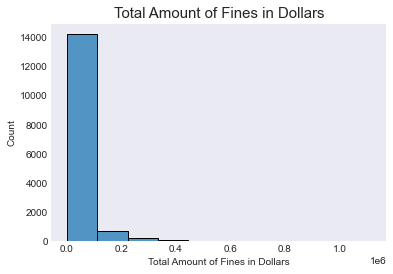

In [29]:
sns.histplot(provider_info_df['Total Amount of Fines in Dollars'], bins=10)
plt.title('Total Amount of Fines in Dollars', fontsize=15)

It appears that we may want to remove outliers > $500,000 or so, later, when we improve the model.

Our dataset has many interesting columns. From inspecting them, we've identified the following numerical and categorical features:

In [30]:
num_cols = [
    'Number of Certified Beds', 'Average Number of Residents per Day', 'Overall Rating', 'Health Inspection Rating', 'QM Rating', 'Long-Stay QM Rating', 
    'Short-Stay QM Rating', 'Staffing Rating', 'RN Staffing Rating', 'Reported Nurse Aide Staffing Hours per Resident per Day',
    'Reported LPN Staffing Hours per Resident per Day', 'Reported RN Staffing Hours per Resident per Day', 'Reported Licensed Staffing Hours per Resident per Day',
    'Reported Total Nurse Staffing Hours per Resident per Day', 'Total number of nurse staff hours per resident per day on the weekend',
    'Registered Nurse hours per resident per day on the weekend', 'Reported Physical Therapist Staffing Hours per Resident Per Day',
    'Total nursing staff turnover', 'Registered Nurse turnover',  'Number of administrators who have left the nursing home',
    'Case-Mix Nurse Aide Staffing Hours per Resident per Day', 'Case-Mix LPN Staffing Hours per Resident per Day', 'Case-Mix RN Staffing Hours per Resident per Day',
    'Case-Mix Total Nurse Staffing Hours per Resident per Day', 'Adjusted Nurse Aide Staffing Hours per Resident per Day',
    'Adjusted LPN Staffing Hours per Resident per Day', 'Adjusted RN Staffing Hours per Resident per Day', 'Adjusted Total Nurse Staffing Hours per Resident per Day',
    'Rating Cycle 1 Total Number of Health Deficiencies', 'Rating Cycle 1 Number of Standard Health Deficiencies',
    'Rating Cycle 1 Number of Complaint Health Deficiencies', 'Rating Cycle 1 Health Deficiency Score', 'Rating Cycle 1 Number of Health Revisits',
    'Rating Cycle 1 Health Revisit Score', 'Rating Cycle 1 Total Health Score', 'Rating Cycle 2 Total Number of Health Deficiencies',
    'Rating Cycle 2 Number of Standard Health Deficiencies', 'Rating Cycle 2 Number of Complaint Health Deficiencies',
    'Rating Cycle 2 Health Deficiency Score', 'Rating Cycle 2 Number of Health Revisits', 'Rating Cycle 2 Health Revisit Score',
    'Rating Cycle 2 Total Health Score', 'Rating Cycle 3 Total Number of Health Deficiencies', 'Rating Cycle 3 Number of Standard Health Deficiencies',
    'Rating Cycle 3 Number of Complaint Health Deficiencies', 'Rating Cycle 3 Health Deficiency Score', 'Rating Cycle 3 Number of Health Revisits',
    'Rating Cycle 3 Health Revisit Score', 'Rating Cycle 3 Total Health Score', 'Total Weighted Health Survey Score', 'Number of Facility Reported Incidents',
    'Number of Substantiated Complaints', 'Number of Citations from Infection Control Inspections']

In [31]:
cat_cols = [
    'Provider City', 'Provider State', 'Provider Zip Code', 'Provider SSA County Code', 'Ownership Type', 'Provider Type', 'Provider Resides in Hospital', 
    'Continuing Care Retirement Community', 'Special Focus Status', 'Abuse Icon', 'Most Recent Health Inspection More Than 2 Years Ago', 
    'Provider Changed Ownership in Last 12 Months', 'With a Resident and Family Council', 'Automatic Sprinkler Systems in All Required Areas',
    'Long-Stay QM Rating Footnote', 'Short-Stay QM Rating Footnote', 'Staffing Rating Footnote', 'RN Staffing Rating Footnote', 'Reported Staffing Footnote', 
    'Physical Therapist Staffing Footnote', 'Total nursing staff turnover footnote', 'Registered Nurse turnover footnote', 'Administrator turnover footnote']
for cat_col in cat_cols:
    provider_info_df[cat_col] = provider_info_df[cat_col].astype('category')

# Creating a Baseline Model

* Minimal feature engineering
* No external datasets
* Linear model

In [32]:
# Transforms categorical, numerical, and binned features using imputation, scaling, and encoding
# Fits the estimator with the training set and returns predicted labels for the X_test set
# Train/test splitting and error computation is left to the caller
def run_baseline_model(X_train, X_test, y_train, estimator, categorical_features=[], numerical_features=[], binned_features=[], n_bins=15):
  numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
  ])

  categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
  ])

  binning_transformer = Pipeline(steps=[
    ('encoder', KBinsDiscretizer(strategy='uniform', n_bins=n_bins))
  ])

  ct = ColumnTransformer(
      remainder='drop',
      transformers=[
        ('numerical', numeric_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features),
        ('binned', binning_transformer, binned_features)
      ]
  )

  # First we fit the transformers to the training set and transform it
  X_train_prepared = pd.DataFrame(
    ct.fit_transform(X_train).toarray(),
    columns=ct.get_feature_names_out())
  
  # Then we only transform the test set to make use of the imputation, scaling, 
  # and categorization parameters from the training set.
  X_test_prepared = pd.DataFrame(
      ct.transform(X_test).toarray(),
      columns=ct.get_feature_names_out())

  estimator.fit(X_train_prepared, y_train)
  y_pred = estimator.predict(X_test_prepared)

  return y_pred

Text(0.5, 1.0, 'Binned Fines')

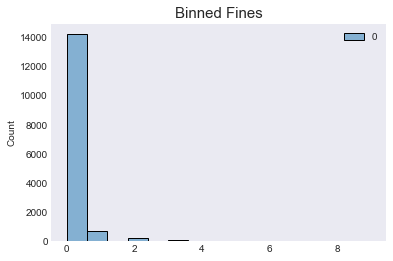

In [33]:
fines = provider_info_df[['Total Amount of Fines in Dollars']]
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
binned_fines = discretizer.fit_transform(fines)
sns.histplot(binned_fines)
plt.title('Binned Fines', fontsize=15)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    provider_info_df, provider_info_df['Total Amount of Fines in Dollars'], 
    train_size=.75, stratify=binned_fines)

y_pred = run_baseline_model(X_train, X_test, y_train, SGDRegressor(), cat_cols, num_cols)

In [35]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.2f}")

RMSE: 48726.87


In [36]:
def plot_actual_vs_predicted(y_test, y_pred, xlabel='Actual Fines (\$)', ylabel='Predicted Fines (\$)'):
    fig = plt.figure(figsize=(5, 5))
    sns.scatterplot(x=y_test, y=y_pred)
    
    all_values = np.concatenate((y_test, y_pred))
    x = np.linspace(np.min(all_values), np.max(all_values))
    y = x

    plt.plot(x, y, color='orange')
    plt.title(f"{xlabel} vs {ylabel}", fontsize=15)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.show()

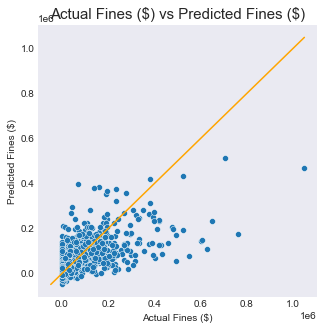

In [37]:
plot_actual_vs_predicted(y_test, y_pred)

# Enhance the Model

## Remove Outliers

In [38]:
# Make a copy of the data frame to keep the original intact
enhanced_model_df = provider_info_df.copy()

fine_amount_feature = 'Total Amount of Fines in Dollars'

enhanced_model_df = enhanced_model_df[enhanced_model_df[fine_amount_feature] < enhanced_model_df[fine_amount_feature].quantile(0.99)]
enhanced_model_df = enhanced_model_df[enhanced_model_df[fine_amount_feature] > enhanced_model_df[fine_amount_feature].quantile(0.01)]
enhanced_model_df.shape

(9359, 96)

## Additional Feature Engineering

## Additional Datasets

Join in state averages and quality MSR data. _Note_ that the MSR set will need to be grouped by the `Federal Provider Number`.

## More Complex Model Types

Perhaps we can use some cross validation here to select a model or use grid search to tune model hyperparameters.

# Summary of Model Improvements

# Minimal Model for Explanatory Purposes

Perhaps use a correlation matrix to find features that don't provide much and remove them.